In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


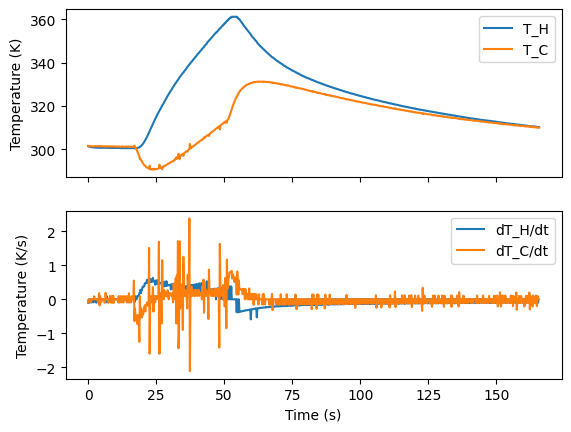

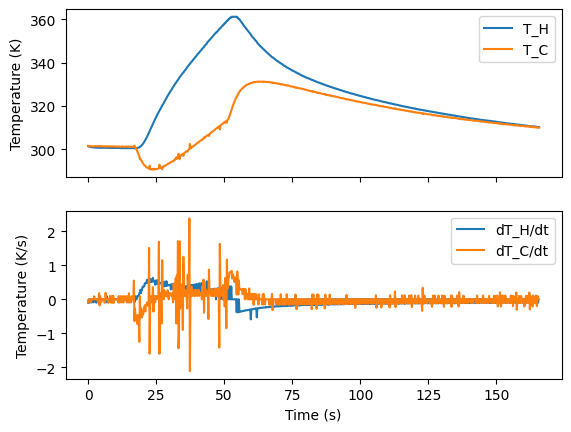

In [4]:
# Read and process the CSV file
df = pd.read_csv("test.csv")
df.columns = ["T_H", "T_C"]
df.insert(0, "Time", [i * 0.2 for i in range(len(df))])
df["T_H"] += 273  # Convert to Kelvin
df["T_C"] += 273

# Interpolation functions for T_h and T_c
interp_T_h = interp1d(df["Time"], df["T_H"], fill_value="extrapolate")
interp_T_c = interp1d(df["Time"], df["T_C"], fill_value="extrapolate")

# Slope of T_h and T_c
slope_T_h = interp_T_h(df["Time"].values[1:]) - interp_T_h(df["Time"].values[:-1])
slope_T_c = interp_T_c(df["Time"].values[1:]) - interp_T_c(df["Time"].values[:-1])

# Subplot with both T_h and T_c
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df["Time"], df["T_H"], label="T_H")
ax[0].plot(df["Time"], df["T_C"], label="T_C")
ax[0].set_ylabel("Temperature (K)")
ax[0].legend()
ax[1].plot(df["Time"].values[:-1], slope_T_h, label="dT_H/dt")
ax[1].plot(df["Time"].values[:-1], slope_T_c, label="dT_C/dt")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Temperature (K/s)")
ax[1].legend()
plt.show()

# plot interpolated T_h and T_c
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df["Time"], interp_T_h(df["Time"]), label="T_H")
ax[0].plot(df["Time"], interp_T_c(df["Time"]), label="T_C")
ax[0].set_ylabel("Temperature (K)")
ax[0].legend()
ax[1].plot(df["Time"].values[:-1], slope_T_h, label="dT_H/dt")
ax[1].plot(df["Time"].values[:-1], slope_T_c, label="dT_C/dt")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Temperature (K/s)")
ax[1].legend()
plt.show()

In [ ]:
# Constants and Parameters
k = 0.075  # Thermal conductivity of NOVEC 7000 [W/mK]
L_c = 0.75 / 1000  # Thickness of the fluid layer [m]
h = 5  # Convective heat transfer coefficient [W/m^2K]

# Peltier Device Parameters
n = 126  # Number of thermocouples in the Peltier device
# Average Seebeck coefficient for N type and P type (in V/K)
alpha_N = (205 + 215) / 2 * 1e-6
alpha_P = (220 + 230) / 2 * 1e-6

# Use an average alpha for the simulation (assuming a mix of N and P types)
alpha = (alpha_N + alpha_P) / 2

I = 5  # Current [A]

# Average Electrical resistance (converted from µΩ·cm to Ohms)
R = (1000 + 1050) / 2 * 1e-6 * 0.01  # Conversion factor for cm to m

V = I*R  # Voltage [V]

P = V*I  # Power [W]

# Average Thermal conductivity for N type and P type (in W/mK)
K_N = (1.3 + 1.4) / 2
K_P = (1.4 + 1.6) / 2

# Use an average K for the simulation (assuming a mix of N and P types)
K = (K_N + K_P) / 2
# T_h = 333  # Hot side temperature [K]
# T_c = 293  # Cold side temperature [K]
T_inf = 293  # Ambient temperature [K]
A = 0.0004  # Surface area [m^2]
p = 1700  # Density of NOVEC 7000 [kg/m^3]
C_p = 1100  # Specific heat capacity [J/kgK]

# Biot Number Calculation
B_i = h * L_c / k

# Check if Biot Number is less than 0.1 for 1-D assumption
if B_i < 0.1:
    print("1-D assumption is valid")
else:
    print("1-D assumption may not be valid")


In [ ]:
# Define the ODE function
def heatModel(t, T):
    T_h = interp_T_h(t)
    T_c = interp_T_c(t)
    q_dot_H = n * (alpha * T_h * I + 0.5 * I**2 * R - K * (T_h - T_c))
    dTdt = (h * A * (T - T_inf) + q_dot_H) / (p * C_p)
    return dTdt


# Define the time span and initial condition for the temperature
time_span = [0, df["Time"].iloc[-1]]  # From 0 to the last time in CSV
T_initial = [df["T_H"].iloc[0]]  # Initial temperature of the fluid in Kelvin

# Solve ODE
sol = solve_ivp(
    heatModel,
    time_span,
    T_initial,
    method="RK45",
    t_eval=np.linspace(0, df["Time"].iloc[-1], 100),
)

# Plotting the results
plt.plot(sol.t, sol.y[0], label="Temperature of the fluid")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Evolution in Thermo-Active Soft Actuator")
plt.legend()
plt.grid(True)
plt.show()